In [6]:
!pip install lightgbm

     |████████████████████████████████| 1.7 MB 3.0 MB/s eta 0:00:01


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data= pd.read_csv('semi_clean_data.csv')
data = data.drop('Unnamed: 0', axis=1)
data = data.dropna()


print(data.shape)

(35742, 21)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.svm import LinearSVC, SVC
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, cross_val_predict

from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc


In [18]:
def run_grid_search(model, param_grid, cat_vars, num_vars, month_transform, cv_num=5):
    features = cat_vars + num_vars

    X = data[features]
    y = data['cd'].values

    print(X.columns)

    new_data = pd.read_csv('test.csv')
    new_data2 = new_data[features]
    
    if (month_transform == 'number') or (month_transform == 'sine-cosine'):
        
        print('converting months to numbers ')
        print('='*20)

        month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                         'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
        X['month'] = X['month'].map(month_mapping)

        new_data2['month'] = new_data2['month'].map(month_mapping)
        
        if month_transform == 'sine-cosine':
            
            print('converting months to sine-cosine ')
            print('='*20)
        
            # Cyclical encoding for 'month'
            X['month_sin'] = np.sin((2 * np.pi * X['month'])/12)
            X['month_cos'] = np.cos((2 * np.pi * X['month'])/12)
            X.drop('month', axis=1, inplace=True)

        cat_vars.remove('month')
    
    print(cat_vars)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    pipeline = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),cat_vars),
                                     (RobustScaler(), num_vars),
                                     remainder='passthrough'
                                    )


    model_hp = make_pipeline(pipeline, model)

    stratified_kfold = StratifiedKFold(n_splits=cv_num, shuffle=True, random_state=42)
    scorer = make_scorer(roc_auc_score)
    grid = GridSearchCV(model_hp, param_grid, cv=stratified_kfold, scoring=scorer, verbose=3)
    # grid = GridSearchCV(model_hp, param_grid, cv=cv_num, scoring='roc_auc', verbose=3)
    grid.fit(X_train, y_train)
    print('Score using train set. = ', grid.score(X_train, y_train))

    # Predict probabilities
    y_pred_prob = grid.predict_proba(X_test)[:,1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    
    best_model = grid.best_estimator_
    new_predictions = best_model.predict(new_data2)
    answer = pd.DataFrame({'ID':list(new_data.id), 'cd':new_predictions})

    return grid, answer

Index(['marital', 'education', 'housing', 'loan', 'contact', 'month',
       'poutcome', 'generation', 'age', 'balance', 'day', 'duration',
       'campaign', 'pdays', 'previous'],
      dtype='object')
['marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'generation']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=10000;, score=0.856 total time= 4.6min
[CV 2/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=10000;, score=0.850 total time= 7.0min
[CV 3/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, rand

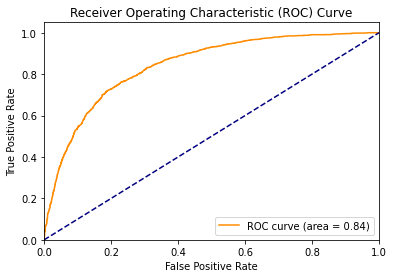

ValueError: columns are missing: {'month_cos', 'month_sin'}

In [12]:
param_grid_rf = {
    'randomforestclassifier__n_estimators': [10000],
    'randomforestclassifier__max_depth': [None],
    'randomforestclassifier__min_samples_split': [2],
    'randomforestclassifier__min_samples_leaf': [1],
    'randomforestclassifier__bootstrap': [True]  # Whether bootstrap samples are used when building trees.
}
ans = run_grid_search(RandomForestClassifier(), param_grid = param_grid_rf,
                      cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation'],
                      num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'])

In [ ]:
param_grid_rf = {
    'randomforestclassifier__n_estimators': [10000],
    'randomforestclassifier__max_depth': [None],
    'randomforestclassifier__min_samples_split': [2],
    'randomforestclassifier__min_samples_leaf': [1],
    'randomforestclassifier__bootstrap': [True]  # Whether bootstrap samples are used when building trees.
}
grid_num, ans_num = run_grid_search(RandomForestClassifier(), param_grid = param_grid_rf,
                      cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation'],
                      num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
                      ,month_transform = 'number'
                     )

Index(['marital', 'education', 'housing', 'loan', 'contact', 'month',
       'poutcome', 'generation', 'age', 'balance', 'day', 'duration',
       'campaign', 'pdays', 'previous'],
      dtype='object')
converting months to numbers 
converting months to sine-cosine 
['marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'generation']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=10000;, score=0.856 total time= 7.7min
[CV 2/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=10000;, score=0.850 total time= 7.9min
[CV 3/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__

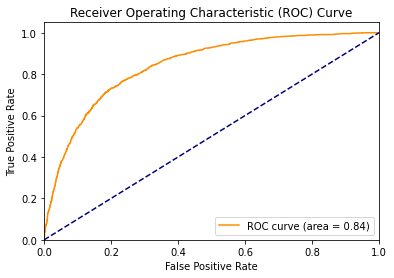

ValueError: columns are missing: {'month_cos', 'month_sin'}

In [14]:
param_grid_rf = {
    'randomforestclassifier__n_estimators': [10000],
    'randomforestclassifier__max_depth': [None],
    'randomforestclassifier__min_samples_split': [2],
    'randomforestclassifier__min_samples_leaf': [1],
    'randomforestclassifier__bootstrap': [True]  # Whether bootstrap samples are used when building trees.
}
grid_sc, ans_sc = run_grid_search(RandomForestClassifier(), param_grid = param_grid_rf,
                      cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation'],
                      num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
                      ,month_transform = 'sine-cosine'
                     )

Index(['marital', 'education', 'housing', 'loan', 'contact', 'month',
       'poutcome', 'generation', 'age', 'balance', 'day', 'duration',
       'campaign', 'pdays', 'previous'],
      dtype='object')
['marital', 'education', 'housing', 'loan', 'contact', 'month', 'poutcome', 'generation']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=10000;, score=0.861 total time= 7.2min
[CV 2/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=10000;, score=0.854 total time= 7.5min
[CV 3/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_lea

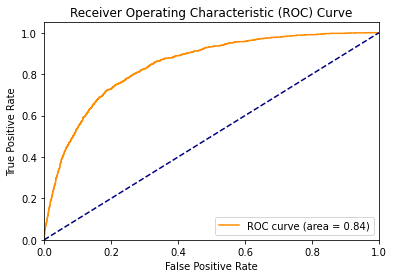

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [15]:
param_grid_rf = {
    'randomforestclassifier__n_estimators': [10000],
    'randomforestclassifier__max_depth': [None],
    'randomforestclassifier__min_samples_split': [5],
    'randomforestclassifier__min_samples_leaf': [1],
    'randomforestclassifier__bootstrap': [True]  # Whether bootstrap samples are used when building trees.
}
grid_cat, ans_cat = run_grid_search(RandomForestClassifier(), param_grid = param_grid_rf,
                      cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation'],
                      num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
                      ,month_transform = 'categorical'
                     )

In [ ]:
param_grid_rf = {
    'randomforestclassifier__n_estimators': [100],
    'randomforestclassifier__max_depth': [None],
    'randomforestclassifier__min_samples_split': [2],
    'randomforestclassifier__min_samples_leaf': [1],
    'randomforestclassifier__bootstrap': [True]  # Whether bootstrap samples are used when building trees.
}
grid_cat, ans_cat = run_grid_search(RandomForestClassifier(), param_grid = param_grid_rf,
                      cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation'],
                      num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
                      ,month_transform = 'categorical'
                     )

Index(['marital', 'education', 'housing', 'loan', 'contact', 'month',
       'poutcome', 'generation', 'age', 'balance', 'day', 'duration',
       'campaign', 'pdays', 'previous'],
      dtype='object')
converting months to numbers 
['marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'generation']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=8, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.728 total time= 9.0min
[CV 2/2] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=8, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.733 total time=12.4min
Score using train set. =  0.8819093589182427


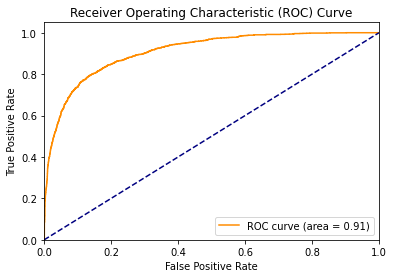

In [20]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [20],
    'xgbclassifier__colsample_bytree': [0.8],
    'xgbclassifier__subsample': [0.8]
#     ,
#     'xgbclassifier__alpha': np.logspace(-2, 2, 4), #[0.1, 0.5, 1], # L1
    # 'classifier__lambda': [0, 0.1, 0.5, 1], # L2
#     'xgbclassifier__gamma': [0.1, 0.5, 1]  # Added gamma to the grid
}
grid_cat, ans_cat = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation'],
                      num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
                      ,cv_num=2
                      ,month_transform = 'number'
                      )

In [21]:
ans_cat.to_csv('RF_results.csv', index=False)

In [25]:
cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation']
num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

features = cat_vars + num_vars

X = data[features]
y = data['cd'].values


new_data = pd.read_csv('test.csv')
new_data2 = new_data[features]

month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                      'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
X['month'] = X['month'].map(month_mapping)

new_data2['month'] = new_data2['month'].map(month_mapping)

cat_vars.remove('month')

best_params = grid_cat.best_params_
best_model = XGBClassifier(n_estimators = 10000,
    learning_rate = 0.001,
    max_depth=20,
    colsample_bytree=0.8,
    subsample=0.8)


pipeline = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),cat_vars),
                                (RobustScaler(), num_vars),
                                remainder='passthrough'
                              )
final_pipeline = make_pipeline(pipeline, best_model)

final_pipeline.fit(X,y)

new_predictions = final_pipeline.predict(new_data2)
answer = pd.DataFrame({'ID':list(new_data.id), 'cd':new_predictions})
answer.to_csv('RF_results_v2.csv', index=False)

KeyboardInterrupt: 